In [1]:
import dann_dual_model as dannd
import training_helper as th
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
import torchvision.models as models
import copy
from torchvision.utils import save_image
import PIL
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math

In [2]:
device = th.getCudaDevice(cudaNum = 0, torchSeed = 123)
batch_size = 1024
my_net = dannd.CNNModel().to(device)
optimizer = optim.Adam(my_net.parameters(), lr=1e-4, betas = (0.5, 0.999))

Device used: cuda:0


In [3]:
img_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

mnist_train = th.labelImgData(root='hw3_data/digits/mnistm/train', transform=img_transform)
mnist_test = th.labelImgData(root='hw3_data/digits/mnistm/test', transform=img_transform)
svhn_train = th.labelImgData(root='hw3_data/digits/svhn/train', transform=img_transform)
svhn_test = th.labelImgData(root='hw3_data/digits/svhn/test', transform=img_transform)
usps_train = th.labelImgData(root='hw3_data/digits/usps/train', transform=img_transform)
usps_test = th.labelImgData(root='hw3_data/digits/usps/test', transform=img_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=0)
svhn_train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True, num_workers=0)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=True, num_workers=0)
usps_train_loader = DataLoader(usps_train, batch_size=batch_size, shuffle=True, num_workers=0)
usps_test_loader = DataLoader(usps_test, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
def test(dataloader, domain= 'target'):
    my_net.eval()
    correct = 0
    for batch_idx, (img, label) in enumerate(dataloader):
        img, label = img.to(device), label.to(device)
        output, _ = my_net(img, domain = domain)
        _, pred = torch.max(output, 1)
        correct += (pred == label).sum()
    my_net.train()
    return correct.item() / len(dataloader.dataset) 

In [6]:
# question 1
sourceList = ['usps', 'mnistm', 'svhn', 'usps']
targetList = [mnist_test_loader, svhn_test_loader, usps_test_loader]
for i in range(3):
    src, tgt, test_loader = sourceList[i], sourceList[i+1], targetList[i]
    fn = 'p4_'+src+'->'+tgt+'_best.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tdomain adaptation accuracy: {:.4f}'.format(test(test_loader)))
    fn = 'p4_'+src+'->'+tgt+'_final.pth'
    th.loadModel(fn , my_net, optimizer)
    print(fn,'\tdomain adaptation accuracy: {:.4f}'.format(test(test_loader)),'\n')

model loaded from p4_usps->mnistm_best.pth
p4_usps->mnistm_best.pth 	domain adaptation accuracy: 0.5122
model loaded from p4_usps->mnistm_final.pth
p4_usps->mnistm_final.pth 	domain adaptation accuracy: 0.5018 

model loaded from p4_mnistm->svhn_best.pth
p4_mnistm->svhn_best.pth 	domain adaptation accuracy: 0.5479
model loaded from p4_mnistm->svhn_final.pth
p4_mnistm->svhn_final.pth 	domain adaptation accuracy: 0.5351 

model loaded from p4_svhn->usps_best.pth
p4_svhn->usps_best.pth 	domain adaptation accuracy: 0.6831
model loaded from p4_svhn->usps_final.pth
p4_svhn->usps_final.pth 	domain adaptation accuracy: 0.5630 



In [6]:
# question 2 func
def getLatentVectorList(src_loader, tgt_loader):
    my_net.eval()
    with torch.no_grad():
        img_src, label_src = iter(src_loader).next()
        img_tgt, label_tgt = iter(tgt_loader).next()
        ratio = math.sqrt(len(src_loader.dataset)/len(tgt_loader.dataset))
        if ratio < 1:
            length = int(ratio*len(img_tgt))
            img_src, label_src = img_src[:length], label_src[:length]
        else:
            length = int(len(img_src)/ratio)
            img_tgt, label_tgt = img_tgt[:length], label_tgt[:length]
        
        feature = my_net.feature_src(img_src.to(device))
        feature = feature.view(-1, 50 * 4 * 4)
        latentVectorList = [feat.cpu().numpy() for feat in feature]
        
        feature = my_net.feature_tgt(img_tgt.to(device))
        feature = feature.view(-1, 50 * 4 * 4)
        latentVectorList += [feat.cpu().numpy() for feat in feature]
        
        labelList = label_src.cpu().numpy().tolist() + label_tgt.cpu().numpy().tolist()
        domainList = np.ones(len(img_src)).tolist() + np.zeros(len(img_tgt)).tolist()
    return np.array(latentVectorList), np.array(labelList), np.array(domainList)

def plotLabelingTSNE(args, ax):
    latentVectorList, labelList, domainList = args
    latentVectorList = TSNE(init='random', random_state = 5).fit_transform(latentVectorList)
    cm = plt.get_cmap('gist_rainbow')
    for label in range(10):
        color = cm(1.*label/10)
        xy = np.array([vec for i, vec in enumerate(latentVectorList) if label == labelList[i]])
        ax[0].scatter(xy[:,0], xy[:,1],s = 8, color = color, label = str(label), alpha = 0.9)
        ax[0].legend()
    for domain in range(2):
        color, gender = ("cornflowerblue", "source domain") if domain else ("hotpink", "target domain")
        xy = np.array([vec for i, vec in enumerate(latentVectorList) if domain == domainList[i]])
        ax[1].scatter(xy[:,0], xy[:,1],s = 8, color = color, label = gender, alpha = 0.9)
        ax[1].legend()

model loaded from p4_usps->mnistm_final.pth
model loaded from p4_mnistm->svhn_final.pth
model loaded from p4_svhn->usps_final.pth


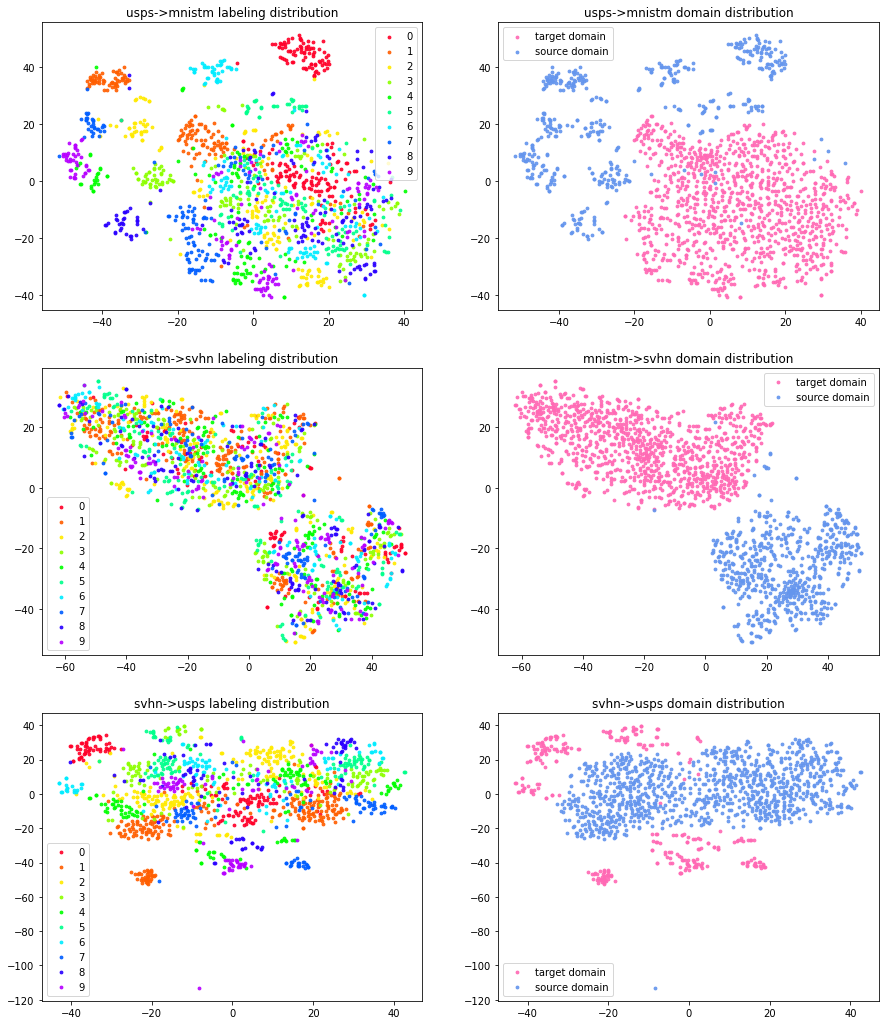

In [7]:
# question 2 repo
fig, ax = plt.subplots(3,2,figsize=(15,18))
srcStrList, srcLoadList = ['usps','mnistm','svhn'], [usps_test_loader, mnist_test_loader, svhn_test_loader]
tgtStrList, tgtLoadList = ['mnistm','svhn','usps'], [mnist_test_loader, svhn_test_loader, usps_test_loader]
stringLoaderTupleList = zip(srcStrList, srcLoadList, tgtStrList, tgtLoadList)

for i, args in enumerate(stringLoaderTupleList):
    srcStr, srcLoad, tgtStr, tgtLoad = args
    th.loadModel('p4_'+srcStr+'->'+tgtStr+'_final.pth' , my_net, optimizer)
    plotLabelingTSNE(getLatentVectorList(srcLoad, tgtLoad), ax[i])
    ax[i][0].set_title(srcStr+'->'+tgtStr+' labeling distribution')
    ax[i][1].set_title(srcStr+'->'+tgtStr+' domain distribution')
    
plt.savefig("hw3_data/p4_report/question2.jpg")
plt.show()

model loaded from p4_usps->mnistm_best.pth
model loaded from p4_mnistm->svhn_best.pth
model loaded from p4_svhn->usps_best.pth


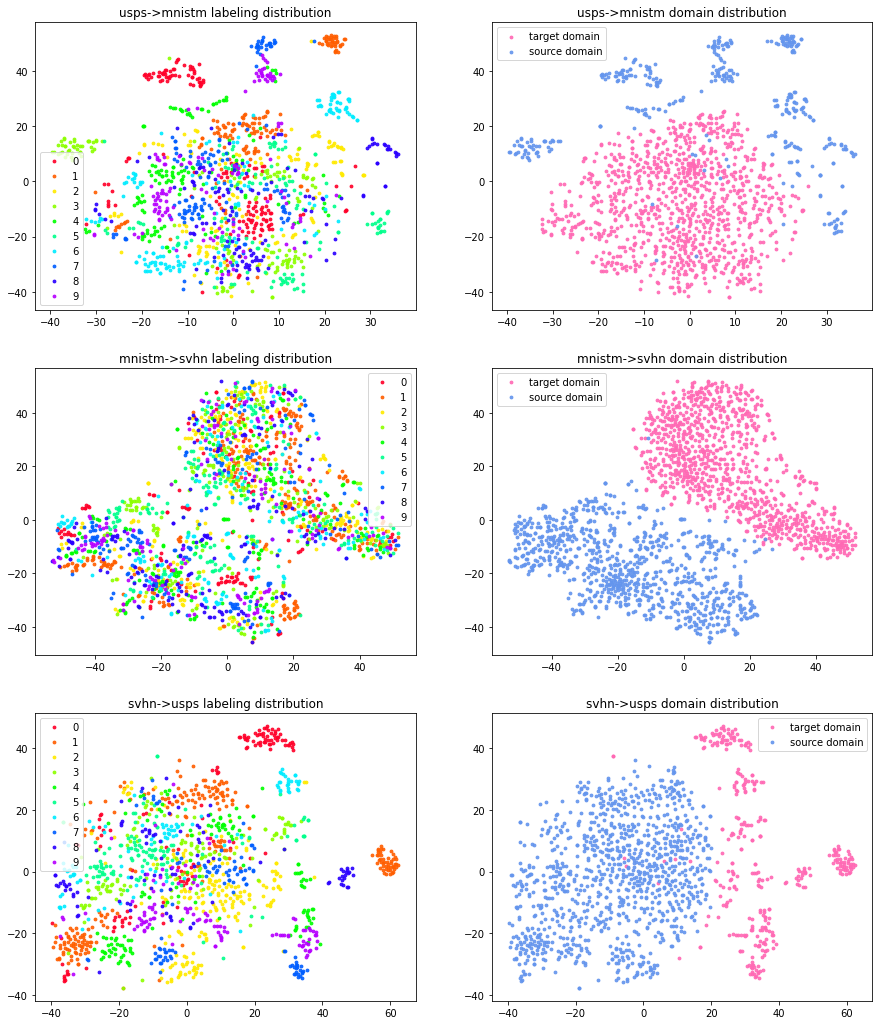

In [8]:
# question 4 best on train
fig, ax = plt.subplots(3,2,figsize=(15,18))
srcStrList, srcLoadList = ['usps','mnistm','svhn'], [usps_train_loader, mnist_train_loader, svhn_train_loader]
tgtStrList, tgtLoadList = ['mnistm','svhn','usps'], [mnist_train_loader, svhn_train_loader, usps_train_loader]
stringLoaderTupleList = zip(srcStrList, srcLoadList, tgtStrList, tgtLoadList)

for i, args in enumerate(stringLoaderTupleList):
    srcStr, srcLoad, tgtStr, tgtLoad = args
    th.loadModel('p4_'+srcStr+'->'+tgtStr+'_best.pth' , my_net, optimizer)
    plotLabelingTSNE(getLatentVectorList(srcLoad, tgtLoad), ax[i])
    ax[i][0].set_title(srcStr+'->'+tgtStr+' labeling distribution')
    ax[i][1].set_title(srcStr+'->'+tgtStr+' domain distribution')
    
plt.savefig("hw3_data/p4_report/question2_best.jpg")
plt.show()